# Multi-Agent MCTS for Retrosynthesis Tutorial

This notebook provides a comprehensive tutorial on the multi-agent Monte Carlo Tree Search (MCTS) system for retrosynthesis planning. The system combines two complementary agents:

1. **DORAnet Agent** - Performs retro-synthetic fragmentation (backward direction)
2. **RetroTide Agent** - Designs polyketide synthase pathways (forward direction)

## Table of Contents
1. [Overview of MCTS](#1-overview-of-mcts)
2. [DORAnet Agent in Isolation](#2-doranet-agent-in-isolation)
3. [RetroTide Agent Overview](#3-retrotide-agent-overview)
4. [Integrated Multi-Agent Workflow](#4-integrated-multi-agent-workflow)
5. [Visualizing the Search Tree](#5-visualizing-the-search-tree)

## Setup

First, let's import the necessary libraries and set up the environment.

In [1]:
import sys
from pathlib import Path

# Add the repository root to the path
REPO_ROOT = Path.cwd().parent
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

# Silence RDKit warnings for cleaner output
from rdkit import RDLogger
RDLogger.DisableLog("rdApp.*")

# Core imports
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display, HTML
import matplotlib.pyplot as plt

print("Setup complete!")

Setup complete!


---

## 1. Overview of MCTS

Monte Carlo Tree Search (MCTS) is a heuristic search algorithm that builds a search tree incrementally through four key phases:

```
┌─────────────┐    ┌─────────────┐    ┌─────────────┐    ┌─────────────────┐
│  SELECTION  │ -> │  EXPANSION  │ -> │   ROLLOUT   │ -> │ BACKPROPAGATION │
│             │    │             │    │ (Simulation)│    │                 │
│ Choose leaf │    │ Add child   │    │ Evaluate    │    │ Update values   │
│ using UCB1  │    │ nodes       │    │ node value  │    │ up the tree     │
└─────────────┘    └─────────────┘    └─────────────┘    └─────────────────┘
```

### UCB1 Selection Policy

The Upper Confidence Bound (UCB1) formula balances **exploitation** (choosing high-value nodes) and **exploration** (trying unvisited nodes):

$$UCB1 = \frac{V_i}{N_i} + \sqrt{\frac{2 \ln N_{parent}}{N_i}}$$

Where:
- $V_i$ = cumulative value of node $i$
- $N_i$ = visit count of node $i$
- $N_{parent}$ = visit count of parent node

---

## 2. DORAnet Agent in Isolation

The DORAnet agent performs **retro-synthetic fragmentation** - it breaks down a target molecule into smaller fragments using:
- **Enzymatic transformations** - From the DORAnet enzymatic reaction database
- **Synthetic transformations** - From the DORAnet synthetic chemistry rules

### 2.1 Understanding the Node Structure

In [2]:
from DORAnet_agent.node import Node

# Reset node counter for clean numbering
Node.node_counter = 0

# Create a simple example
mol = Chem.MolFromSmiles("CCCC(C)=O")  # 3-pentanone

# Create a root node
root = Node(
    fragment=mol,
    parent=None,
    depth=0,
    provenance="target"  # This is our starting target
)

print("Node Structure:")
print(f"  node_id:    {root.node_id}")
print(f"  smiles:     {root.smiles}")
print(f"  depth:      {root.depth}")
print(f"  provenance: {root.provenance}")
print(f"  visits:     {root.visits}")
print(f"  value:      {root.value}")
print(f"  expanded:   {root.expanded}")
print(f"  children:   {root.children}")

/Users/yashchainani/Desktop/PythonProjects/RetroTideV2/bcs/bcs.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


































































































































































































































































































































["AT{'substrate': 'isobutmal'}", "KR{'type': 'A1'}", 'loading: False']
["AT{'substrate': 'mxmal'}", "KR{'type': 'B2'}", 'loading: False']
["AT{'substrate': 'emal'}", "KR{'type': 'B1'}", 'DH{}', 'ER{}', 'loading: False']
["AT{'substrate': 'hmal'}", "KR{'type': 'B1'}", 'loading: False']
["AT{'substrate': 'D-isobutmal'}", "KR{'type': 'B1'}", 'DH{}', 'ER{}', 'loading: False']
["AT{'substrate': 'D-isobutmal'}", "KR{'type': 'B1'}", 'loading: False']
["AT{'substrate': 'hexmal'}", "KR{'type': 'A2'}", 'loading: False']
["AT{'substrate': 'isobutmal'}", "KR{'type': 'B1'}", 'DH{}', 'loading: False']
["AT{'substrate': 'emal'}", "KR{'type': 'C1'}", 'loading: False']
["AT{'substrate': '

Target molecule: 3-pentanone (CCCC(C)=O)


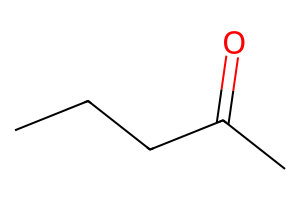

In [3]:
# Visualize the target molecule
print("Target molecule: 3-pentanone (CCCC(C)=O)")
Draw.MolToImage(mol, size=(300, 200))

### 2.2 Node Relationships

Let's manually create a small tree to understand parent-child relationships:

In [4]:
# Reset counter
Node.node_counter = 0

# Create parent
parent_mol = Chem.MolFromSmiles("CCCC(C)=O")
parent = Node(fragment=parent_mol, parent=None, depth=0, provenance="target")

# Create children (simulated fragments)
child1_mol = Chem.MolFromSmiles("CCC")  # propane
child2_mol = Chem.MolFromSmiles("CC=O")  # acetaldehyde

child1 = Node(fragment=child1_mol, parent=None, provenance="synthetic")
child2 = Node(fragment=child2_mol, parent=None, provenance="enzymatic")

# Add children to parent
parent.add_child(child1)
parent.add_child(child2)

print("Tree Structure:")
print(f"Parent (Node {parent.node_id}): {parent.smiles}")
print(f"  ├── Child 1 (Node {child1.node_id}): {child1.smiles} [depth={child1.depth}, via {child1.provenance}]")
print(f"  └── Child 2 (Node {child2.node_id}): {child2.smiles} [depth={child2.depth}, via {child2.provenance}]")
print(f"\nChild 1's parent: Node {child1.parent.node_id}")

Tree Structure:
Parent (Node 0): CCCC(C)=O
  ├── Child 1 (Node 1): CCC [depth=1, via synthetic]
  └── Child 2 (Node 2): CC=O [depth=1, via enzymatic]

Child 1's parent: Node 0


### 2.3 The DORAnet MCTS Agent

Now let's look at the full DORAnet MCTS implementation. The agent:
1. **Selects** a leaf node using UCB1
2. **Expands** it by applying DORAnet retro-transformations
3. Optionally **spawns RetroTide** searches for each fragment

In [5]:
from DORAnet_agent import DORAnetMCTS, Node

# Reset node counter
Node.node_counter = 0

# Create target molecule
target_smiles = "CCCC(C)=O"  # 3-pentanone
target_molecule = Chem.MolFromSmiles(target_smiles)

# Create root node
root = Node(fragment=target_molecule, parent=None, depth=0, provenance="target")

# Create the agent (without RetroTide spawning for now)
agent = DORAnetMCTS(
    root=root,
    target_molecule=target_molecule,
    total_iterations=5,        # Small number for demonstration
    max_depth=2,               # Shallow tree
    use_enzymatic=True,        # Use enzymatic transformations
    use_synthetic=True,        # Use synthetic transformations
    generations_per_expand=1,  # DORAnet generations per expansion
    max_children_per_expand=3, # Limit children for cleaner output
    spawn_retrotide=False,     # Disable RetroTide for now
)

print("DORAnet MCTS Agent Configuration:")
print(f"  Target:           {target_smiles}")
print(f"  Total iterations: {agent.total_iterations}")
print(f"  Max depth:        {agent.max_depth}")
print(f"  Use enzymatic:    {agent.use_enzymatic}")
print(f"  Use synthetic:    {agent.use_synthetic}")
print(f"  Spawn RetroTide:  {agent.spawn_retrotide}")

[DORAnet] Preprocessed target molecule:
[DORAnet]   Original SMILES: CCCC(C)=O
[DORAnet]   Canonical SMILES (no stereo): CCCC(C)=O
[DORAnet] Target MW: 86.13, Max fragment MW: 129.20 (excluding fragments > 1.5x target)
[DORAnet] Selection policy: depth_biased (coefficient=2.0) - favoring deeper exploration
[DORAnet] Child downselection: first_N (DORAnet order)
[DORAnet] Using rollout policy: NoOp
[DORAnet] Using reward policy: SparseTerminal(sink_reward=1.0)
[DORAnet] DORA-XGB available for enzymatic feasibility scoring
[DORAnet] pathermo available for synthetic thermodynamic scoring
DORAnet MCTS Agent Configuration:
  Target:           CCCC(C)=O
  Total iterations: 5
  Max depth:        2
  Use enzymatic:    True
  Use synthetic:    True
  Spawn RetroTide:  False


### 2.4 Running DORAnet MCTS

Let's run the DORAnet agent and observe how it expands the tree:

In [6]:
# Run the MCTS search
print("Running DORAnet MCTS...\n")
agent.run()

print("\n" + "="*60)
print("Search Complete!")
print("="*60)

Running DORAnet MCTS...

[DORAnet] Starting MCTS with 5 iterations, max_depth=2
Job name: doranet_enzymatic_retro_c8b15e51
Job type: enzymatic network expansion retro
Job started on: 2026-02-07 23:01:54.005656
Number of generations: 1
Number of operators loaded: 3571
Number of molecules before expantion (including cofactors): 42
Number of molecules after expantion (including cofactors): 121
Number of reactions: 85
Time used for network generation: 0.34 minutes

Job name: doranet_synthetic_retro_b558d01f
Job type: synthetic network expansion retro
Job started on: 2026-02-07 23:02:16.275414
Number of generations: 1
Number of operators: 384
Number of molecules before expantion: 1
Number of molecules after expantion: 12
Number of reactions: 9
Time used for network generation: 0.00 minutes

[DORAnet] Fragment Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O exceeds MW threshold (507.2 > 129.2) - skipping
[DORAnet] Fragment Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)O)[C

In [7]:
# View the tree summary
print(agent.get_tree_summary())

DORAnet MCTS Tree Summary:
Node 0: CCCC(C)=O (depth=0, visits=13, value=0.00, via=target) 
  Node 1: C=CCC(C)=O (depth=1, visits=5, value=0.00, via=synthetic) 
  Node 2: CC=CC(C)=O (depth=1, visits=4, value=0.00, via=synthetic) 
  Node 3: C=CC (depth=1, visits=4, value=0.00, via=synthetic) 
    Node 4: C=C=CC(C)=O (depth=2, visits=2, value=0.00, via=synthetic) 
    Node 5: C=C=C (depth=2, visits=1, value=0.00, via=synthetic) 
    Node 6: C=C=O (depth=2, visits=1, value=0.00, via=synthetic) 
    Node 7: C=C=CC(C)=O (depth=2, visits=1, value=0.00, via=synthetic) 
    Node 8: CC#CC(C)=O (depth=2, visits=1, value=0.00, via=synthetic) 
    Node 9: CBr (depth=2, visits=1, value=0.00, via=synthetic) 
    Node 10: C=C=C (depth=2, visits=1, value=0.00, via=synthetic) 
    Node 11: C#CC (depth=2, visits=1, value=0.00, via=synthetic) 
    Node 12: CBr (depth=2, visits=1, value=0.00, via=synthetic) 


### 2.5 Understanding the Selection Step

Let's manually trace through the UCB1 selection process:

In [8]:
import math

def explain_ucb1_selection(node):
    """Explain UCB1 selection step by step."""
    if not node.children:
        print(f"Node {node.node_id} has no children - it IS the leaf.")
        return node
    
    print(f"Selecting from Node {node.node_id}'s children:")
    print(f"  Parent visits: {node.visits}")
    log_parent = math.log(max(node.visits, 1))
    print(f"  log(parent_visits) = {log_parent:.3f}\n")
    
    for child in node.children:
        if child.visits == 0:
            score = float('inf')
            print(f"  Child {child.node_id} ({child.smiles[:20]}...):")
            print(f"    visits=0 → score = ∞ (prioritize unvisited)")
        else:
            exploit = child.value / child.visits
            explore = math.sqrt(2 * log_parent / child.visits)
            score = exploit + explore
            print(f"  Child {child.node_id} ({child.smiles[:20]}...):")
            print(f"    value={child.value:.2f}, visits={child.visits}")
            print(f"    exploit = {child.value}/{child.visits} = {exploit:.3f}")
            print(f"    explore = sqrt(2 * {log_parent:.3f} / {child.visits}) = {explore:.3f}")
            print(f"    UCB1 score = {exploit:.3f} + {explore:.3f} = {score:.3f}")
        print()

# Demonstrate on our tree
if agent.root.children:
    explain_ucb1_selection(agent.root)
else:
    print("Root has no children yet.")

Selecting from Node 0's children:
  Parent visits: 13
  log(parent_visits) = 2.565

  Child 1 (C=CCC(C)=O...):
    value=0.00, visits=5
    exploit = 0.0/5 = 0.000
    explore = sqrt(2 * 2.565 / 5) = 1.013
    UCB1 score = 0.000 + 1.013 = 1.013

  Child 2 (CC=CC(C)=O...):
    value=0.00, visits=4
    exploit = 0.0/4 = 0.000
    explore = sqrt(2 * 2.565 / 4) = 1.132
    UCB1 score = 0.000 + 1.132 = 1.132

  Child 3 (C=CC...):
    value=0.00, visits=4
    exploit = 0.0/4 = 0.000
    explore = sqrt(2 * 2.565 / 4) = 1.132
    UCB1 score = 0.000 + 1.132 = 1.132



### 2.6 Visualizing Fragments

Let's visualize some of the fragments discovered by DORAnet:

In [ ]:
# Collect unique fragments from depth 1
depth1_nodes = [n for n in agent.nodes if n.depth == 1]

if depth1_nodes:
    # Get unique SMILES
    unique_fragments = {}
    for node in depth1_nodes:
        if node.smiles and node.smiles not in unique_fragments:
            unique_fragments[node.smiles] = (node.fragment, node.provenance)
    
    print(f"Unique fragments at depth 1: {len(unique_fragments)}")
    print()
    
    # Display first few
    mols_to_show = []
    legends = []
    for i, (smi, (mol, prov)) in enumerate(list(unique_fragments.items())[:6]):
        if mol:
            mols_to_show.append(mol)
            short_smi = smi[:25] + "..." if len(smi) > 25 else smi
            legends.append(f"{prov}\n{short_smi}")
    
    if mols_to_show:
        img = Draw.MolsToGridImage(mols_to_show, molsPerRow=3, subImgSize=(250, 200), legends=legends)
        display(img)
else:
    print("No depth 1 nodes found.")

---

## 3. RetroTide Agent Overview

The RetroTide agent works in the **forward direction** - it designs polyketide synthase (PKS) assembly lines that can build a target molecule from simple acyl-CoA building blocks.

### Key Differences from DORAnet:

| Aspect | DORAnet | RetroTide |
|--------|---------|----------|
| Direction | Retro (backward) | Forward |
| Goal | Fragment molecule | Build molecule |
| Node state | Fragment molecule | PKS design + product |
| Reward | Currently none | Design score / exact match |
| MCTS phases | Selection + Expansion | Full (Selection, Expansion, Rollout, Backprop) |

In [ ]:
# Import RetroTide components
try:
    from RetroTide_agent.mcts import MCTS as RetroTideMCTS
    from RetroTide_agent.node import Node as RetroTideNode
    RETROTIDE_AVAILABLE = True
    print("RetroTide agent available!")
except ImportError as e:
    RETROTIDE_AVAILABLE = False
    print(f"RetroTide not available: {e}")

### 3.1 RetroTide Node Structure

The RetroTide node is more complex than DORAnet's - it stores:
- `PKS_product`: The molecule produced by the PKS design
- `PKS_design`: A tuple of (cluster design, score, molecule)
- Standard MCTS bookkeeping (visits, value, etc.)

In [ ]:
if RETROTIDE_AVAILABLE:
    # Reset counter
    RetroTideNode.node_counter = 0
    
    # Create a root node (starts empty - no PKS design yet)
    rt_root = RetroTideNode(
        PKS_product=None,
        PKS_design=None,
        parent=None,
        depth=0
    )
    
    print("RetroTide Node Structure:")
    print(f"  node_id:    {rt_root.node_id}")
    print(f"  PKS_product: {rt_root.PKS_product}")
    print(f"  PKS_design:  {rt_root.PKS_design}")
    print(f"  depth:      {rt_root.depth}")
    print(f"  visits:     {rt_root.visits}")
    print(f"  value:      {rt_root.value}")
else:
    print("RetroTide not available - skipping this section.")

### 3.2 RetroTide MCTS Phases

RetroTide implements the full MCTS algorithm:

1. **Selection**: UCB1 with early pruning (discards nodes that aren't subgraphs of target)
2. **Expansion**: Uses RetroTide library to generate PKS designs
3. **Rollout/Simulation**: Runs full PKS design synthesis, tries release mechanisms
4. **Backpropagation**: Propagates reward up the tree

```python
# Pseudocode for RetroTide MCTS
for iteration in range(total_iterations):
    leaf = select(root)           # UCB1 with subgraph pruning
    expand(leaf)                  # Generate PKS designs
    reward = simulate(leaf)       # Try thiolysis/cyclization release
    backpropagate(leaf, reward)   # Update values up the tree
```

---

## 4. Integrated Multi-Agent Workflow

The power of this system comes from combining both agents:

```
┌─────────────────────────────────────────────────────────────────────┐
│                        DORAnet MCTS (Retro)                        │
│                                                                     │
│    Target Molecule                                                  │
│          │                                                          │
│          ▼                                                          │
│    ┌─────────────┐                                                  │
│    │ Fragment 1  │──────────────────────────────────┐               │
│    └─────────────┘                                  │               │
│          │                                          ▼               │
│    ┌─────────────┐                    ┌─────────────────────────┐   │
│    │ Fragment 2  │─────────────────── │   RetroTide MCTS        │   │
│    └─────────────┘                    │   (Forward PKS design)  │   │
│          │                            │                         │   │
│    ┌─────────────┐                    │   Acyl-CoA → PKS → Mol  │   │
│    │ Fragment 3  │─────────────────── │                         │   │
│    └─────────────┘                    └─────────────────────────┘   │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
```

### 4.1 Running the Integrated System

In [ ]:
# Reset node counters
Node.node_counter = 0

# Create target
target_smiles = "CCCC(C)=O"
target_molecule = Chem.MolFromSmiles(target_smiles)
root = Node(fragment=target_molecule, parent=None, depth=0, provenance="target")

# Create agent WITH RetroTide spawning
integrated_agent = DORAnetMCTS(
    root=root,
    target_molecule=target_molecule,
    total_iterations=3,         # Very small for demo
    max_depth=1,                # Only 1 level deep
    use_enzymatic=False,        # Only synthetic for faster demo
    use_synthetic=True,
    max_children_per_expand=2,  # Very few children
    spawn_retrotide=True,       # ENABLE RetroTide spawning
    retrotide_kwargs=dict(
        max_depth=3,
        total_iterations=10,    # Very small for demo
        maxPKSDesignsRetroTide=5,
        selection_policy="UCB1",
        save_logs=False,
    ),
)

print("Integrated Agent Configuration:")
print(f"  DORAnet iterations: {integrated_agent.total_iterations}")
print(f"  Spawn RetroTide: {integrated_agent.spawn_retrotide}")
print(f"  RetroTide iterations per fragment: {integrated_agent.retrotide_kwargs.get('total_iterations', 'N/A')}")

In [ ]:
# Run the integrated search
print("Running integrated DORAnet + RetroTide search...\n")
print("(Each fragment spawns a RetroTide search)\n")
print("="*60)

integrated_agent.run()

print("\n" + "="*60)
print("Search Complete!")
print("="*60)

In [ ]:
# Summary of results
print("\nIntegrated Search Results:")
print(f"  DORAnet nodes: {len(integrated_agent.nodes)}")
print(f"  RetroTide runs spawned: {len(integrated_agent.retrotide_runs)}")

if integrated_agent.retrotide_runs:
    print("\n  RetroTide searches:")
    for i, rt in enumerate(integrated_agent.retrotide_runs):
        target_smi = Chem.MolToSmiles(rt.target_molecule)
        short_smi = target_smi[:40] + "..." if len(target_smi) > 40 else target_smi
        successful = len(getattr(rt, 'successful_nodes', []))
        print(f"    [{i}] Target: {short_smi}")
        print(f"        Successful: {successful}")

### 4.2 The Cascade Architecture

The key insight is that DORAnet and RetroTide form a **cascade**:

1. **DORAnet** explores the retro-synthetic space, fragmenting the target
2. When a fragment is discovered, **RetroTide** attempts to synthesize it
3. The success/failure of RetroTide can (in future versions) inform DORAnet's search

This creates a feedback loop where:
- Fragments that can be synthesized by PKS are valuable
- DORAnet should prefer paths that lead to synthesizable fragments

---

## 5. Visualizing the Search Tree

Let's create a simple visualization of the DORAnet search tree:

In [ ]:
def print_tree(node, prefix="", is_last=True):
    """Recursively print the tree structure."""
    connector = "└── " if is_last else "├── "
    
    # Truncate long SMILES
    smi = node.smiles if node.smiles else "None"
    short_smi = smi[:30] + "..." if len(smi) > 30 else smi
    
    print(f"{prefix}{connector}[{node.node_id}] {short_smi}")
    print(f"{prefix}{'    ' if is_last else '│   '}    visits={node.visits}, via={node.provenance}")
    
    # Process children
    children = node.children
    for i, child in enumerate(children):
        is_last_child = (i == len(children) - 1)
        new_prefix = prefix + ("    " if is_last else "│   ")
        print_tree(child, new_prefix, is_last_child)

print("DORAnet Search Tree:")
print()
print_tree(agent.root, "", True)

### 5.1 Tree Statistics

In [ ]:
# Compute tree statistics
depths = [n.depth for n in agent.nodes]
provenances = [n.provenance for n in agent.nodes if n.provenance]

print("Tree Statistics:")
print(f"  Total nodes: {len(agent.nodes)}")
print(f"  Max depth: {max(depths) if depths else 0}")
print(f"  Nodes by depth:")
for d in range(max(depths) + 1):
    count = depths.count(d)
    print(f"    Depth {d}: {count} nodes")

print(f"\n  Nodes by provenance:")
for prov in set(provenances):
    count = provenances.count(prov)
    print(f"    {prov}: {count} nodes")

---

## Summary

This tutorial covered:

1. **MCTS Basics**: The four phases (Selection, Expansion, Rollout, Backpropagation) and UCB1

2. **DORAnet Agent**: 
   - Performs retro-synthetic fragmentation
   - Uses enzymatic and synthetic transformations
   - Currently implements Selection + Expansion

3. **RetroTide Agent**:
   - Designs PKS assembly lines
   - Implements full MCTS with reward backpropagation
   - Returns success when target can be synthesized

4. **Integration**:
   - DORAnet spawns RetroTide for each fragment
   - Creates a cascade from retro-synthesis to forward synthesis

### Future Improvements

- **Add Rollout to DORAnet**: Simulate deeper fragmentation
- **Add Backpropagation**: Use RetroTide success to update DORAnet values
- **Polyketide Filtering**: Only spawn RetroTide for polyketide-like fragments
- **Parallel Execution**: Run RetroTide searches in parallel

In [ ]:
print("Tutorial complete!")